In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [8]:
prices_day__2 = pd.read_csv(r"C:\Users\Usuario1\Desktop\quant\IMC_Prosperity\Round1\round-1-island-data-bottle\prices_round_1_day_-2.csv",sep = ";")
prices_day__2 = prices_day__2[prices_day__2["product"] == "KELP"]
prices_day__2["day"] = -2
prices_day__1 = pd.read_csv(r"C:\Users\Usuario1\Desktop\quant\IMC_Prosperity\Round1\round-1-island-data-bottle\prices_round_1_day_-1.csv",sep = ";")
prices_day__1 = prices_day__1[prices_day__1["product"] == "KELP"]
prices_day__1["day"] = -1
prices_day_0 =pd.read_csv(r"C:\Users\Usuario1\Desktop\quant\IMC_Prosperity\Round1\round-1-island-data-bottle\prices_round_1_day_0.csv",sep = ";")
prices_day_0 = prices_day_0[prices_day_0["product"] == "KELP"]
prices_day_0["day"] = 0
all_prices = pd.concat([prices_day__2, prices_day__1, prices_day_0])


In [5]:
all_prices.columns

Index(['day', 'timestamp', 'product', 'bid_price_1', 'bid_volume_1',
       'bid_price_2', 'bid_volume_2', 'bid_price_3', 'bid_volume_3',
       'ask_price_1', 'ask_volume_1', 'ask_price_2', 'ask_volume_2',
       'ask_price_3', 'ask_volume_3', 'mid_price', 'profit_and_loss'],
      dtype='object')

In [9]:
all_prices = all_prices.sort_values(by=['day', 'timestamp']).reset_index(drop=True)

# 2) Create a simple future return: next mid_price / current mid_price - 1
# Shift by -1 means we look one step ahead
all_prices['future_return'] = (all_prices['mid_price'].shift(-1) - all_prices['mid_price']) / all_prices['mid_price']

# Because of the shift, the last row won't have a future_return
all_prices.dropna(subset=['future_return'], inplace=True)

# 3) For classification, define an UP/DOWN label 
#    (1 if future_return > 0, 0 if future_return <= 0)
all_prices['future_return_label'] = (all_prices['future_return'] > 0).astype(int)

In [23]:
all_prices['spread_1'] = all_prices['ask_price_1'] - all_prices['bid_price_1']

# Total bid volume (levels 1..3)
all_prices['total_bid_vol'] = (all_prices['bid_volume_1'].fillna(0) +
                               all_prices['bid_volume_2'].fillna(0) +
                               all_prices['bid_volume_3'].fillna(0))

# Total ask volume (levels 1..3)
all_prices['total_ask_vol'] = (all_prices['ask_volume_1'].fillna(0) +
                               all_prices['ask_volume_2'].fillna(0) +
                               all_prices['ask_volume_3'].fillna(0))

# Order book volume imbalance
all_prices['volume_imbalance'] = (
    all_prices['total_bid_vol'] / (all_prices['total_bid_vol'] + all_prices['total_ask_vol'] + 1e-9)
)

# Rolling feature: for example, a 5-row rolling average of mid_price
all_prices['mid_price_rolling_mean'] = all_prices['mid_price'].rolling(window=5).mean()
all_prices['mid_price_rolling_mean'] = all_prices['mid_price_rolling_mean'].bfill()

# Momentum-like feature
all_prices['momentum'] = all_prices['mid_price'] - all_prices['mid_price_rolling_mean']

In [24]:
feature_cols = [
    'spread_1',
    'total_bid_vol',
    'total_ask_vol',
    'volume_imbalance',
    'momentum'
    # ... add more if you like
]

# Prepare X and y for both regression and classification
X = all_prices[feature_cols].copy().dropna()

# For a REGRESSION target:
y_reg = all_prices['future_return'].copy().dropna()

# For a CLASSIFICATION target:
y_clf = all_prices['future_return_label'].copy().dropna()


In [25]:
all_prices

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,...,mid_price,profit_and_loss,future_return,future_return_label,spread_1,total_bid_vol,total_ask_vol,volume_imbalance,mid_price_rolling_mean,momentum
0,-2,0,KELP,1998,26,NaN,NaN,NaN,NaN,2002,...,2000.0,0.0,0.000500,1,4,26.0,26.0,0.500000,2000.5,-0.5
1,-2,100,KELP,2000,5,1999.0,6.0,1998.0,20.0,2002,...,2001.0,0.0,-0.000250,0,2,31.0,20.0,0.607843,2000.5,0.5
2,-2,200,KELP,1999,1,1998.0,30.0,NaN,NaN,2002,...,2000.5,0.0,0.000000,0,3,31.0,31.0,0.500000,2000.5,0.0
3,-2,300,KELP,1999,27,NaN,NaN,NaN,NaN,2002,...,2000.5,0.0,0.000000,0,3,27.0,27.0,0.500000,2000.5,0.0
4,-2,400,KELP,1999,20,NaN,NaN,NaN,NaN,2002,...,2000.5,0.0,0.000500,1,3,20.0,20.0,0.500000,2000.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29994,0,999400,KELP,2032,26,NaN,NaN,NaN,NaN,2035,...,2033.5,0.0,0.000000,0,3,26.0,26.0,0.500000,2033.4,0.1
29995,0,999500,KELP,2032,28,NaN,NaN,NaN,NaN,2035,...,2033.5,0.0,0.000000,0,3,28.0,28.0,0.500000,2033.4,0.1
29996,0,999600,KELP,2032,36,NaN,NaN,NaN,NaN,2035,...,2033.5,0.0,0.000492,1,3,36.0,29.0,0.553846,2033.4,0.1
29997,0,999700,KELP,2034,1,2032.0,26.0,NaN,NaN,2035,...,2034.5,0.0,-0.000737,0,1,27.0,26.0,0.509434,2033.7,0.8


In [26]:
train_size = int(len(all_prices) * 0.8)  # 80% train, 20% test

X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_reg_train, y_reg_test = y_reg.iloc[:train_size], y_reg.iloc[train_size:]
y_clf_train, y_clf_test = y_clf.iloc[:train_size], y_clf.iloc[train_size:]


In [27]:
X_train

,spread_1,total_bid_vol,total_ask_vol,volume_imbalance,momentum
0,4,26.0,26.0,0.500000,-0.5
1,2,31.0,20.0,0.607843,0.5
2,3,31.0,31.0,0.500000,0.0
3,3,27.0,27.0,0.500000,0.0
4,3,20.0,20.0,0.500000,0.0
...,...,...,...,...,...
23994,3,27.0,27.0,0.500000,0.0
23995,4,31.0,31.0,0.500000,0.3
23996,4,24.0,24.0,0.500000,0.2
23997,2,20.0,22.0,0.476190,-0.7


In [33]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score

lin_reg = Ridge(alpha=0.1)
lin_reg.fit(X_train, y_reg_train)

y_reg_pred = lin_reg.predict(X_test)

mse = mean_squared_error(y_reg_test, y_reg_pred)
r2 = r2_score(y_reg_test, y_reg_pred)
print("Linear Regression - MSE:", mse)
print("Linear Regression - R^2:", r2)


Linear Regression - MSE: 8.723607798118354e-08
Linear Regression - R^2: 0.3709842010145341


In [38]:
mean_squared_error(np.sign(y_reg_pred),np.sign(y_reg_test))

0.9966666666666667

In [40]:
print( lin_reg.coef_)
print(lin_reg.intercept_)


[ 3.75157646e-06 -3.15786104e-05  3.44843719e-05  1.33571738e-03
 -3.54871450e-04]
-0.0007536618536580788


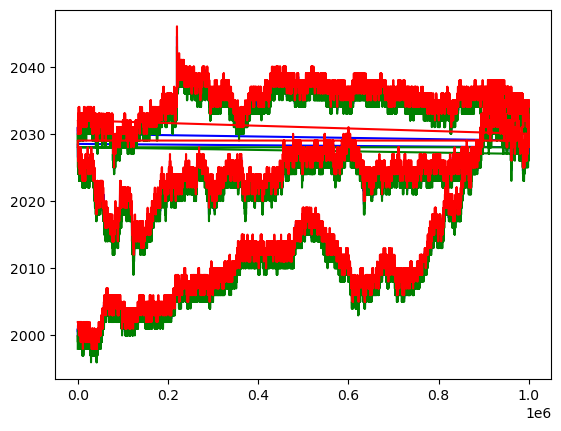

In [29]:
#First lets focus on bid_price_1, ask_price_1 and its mid and plot them:
all_prices["mid_price_1"] = (all_prices["bid_price_1"] + all_prices["ask_price_1"])/2
plt.plot(all_prices["timestamp"], all_prices["mid_price_1"],label = "Mid price",color = "blue")
plt.plot(all_prices["timestamp"], all_prices["bid_price_1"],label = "Best bid",color = "green")
plt.plot(all_prices["timestamp"], all_prices["ask_price_1"],label = "Best ask",color = "red")

In [30]:
import plotly.graph_objects as go

# Create a figure
fig = go.Figure()

timestamp_offset = 0
for day, day_data in [(-2, prices_day__2), (-1, prices_day__1), (0, prices_day_0)]:
    # Create a copy of the data with adjusted timestamps
    day_copy = day_data.copy()
    day_copy.index = day_copy.index + timestamp_offset
    day_copy["mid_price_1"] = (day_copy["bid_price_1"] + day_copy["ask_price_1"]) / 2

    # Add vertical lines and annotations for day markers
    if timestamp_offset > 0:
        fig.add_vline(x=timestamp_offset, line=dict(color="black", dash="dash"), opacity=0.5)
        fig.add_annotation(x=timestamp_offset + 50, y=day_data['bid_price_1'].mean(),
                           text=f'Day {day}', showarrow=False, bgcolor="white", opacity=0.5)

    # Add bid and ask price plots
    if 'bid_price_1' in day_copy.columns and 'ask_price_1' in day_copy.columns:
        fig.add_trace(go.Scatter(x=day_copy.index[::10], y=day_copy['bid_price_1'][::10],
                                 mode='lines', name=f'Bid Price 1 (Day {day})' if timestamp_offset == 0 else "",
                                 line=dict(color='blue')))
        fig.add_trace(go.Scatter(x=day_copy.index[::10], y=day_copy['ask_price_1'][::10],
                                 mode='lines', name=f'Ask Price 1 (Day {day})' if timestamp_offset == 0 else "",
                                 line=dict(color='red')))
        fig.add_trace(go.Scatter(x=day_copy.index[::10], y=day_copy['mid_price_1'][::10],
                                 mode='lines', name=f'Mid Price 1 (Day {day})' if timestamp_offset == 0 else "",
                                 line=dict(color='green')))

    # Update the offset for the next day
    timestamp_offset = max(day_copy.index) + 100  # Add a gap between days

# Update layout for better visualization
fig.update_layout(title="Interactive Plot of Bid and Ask Prices",
                  xaxis_title="Timestamp",
                  yaxis_title="Price",
                  legend_title="Legend")

# Show the interactive plot
fig.show()



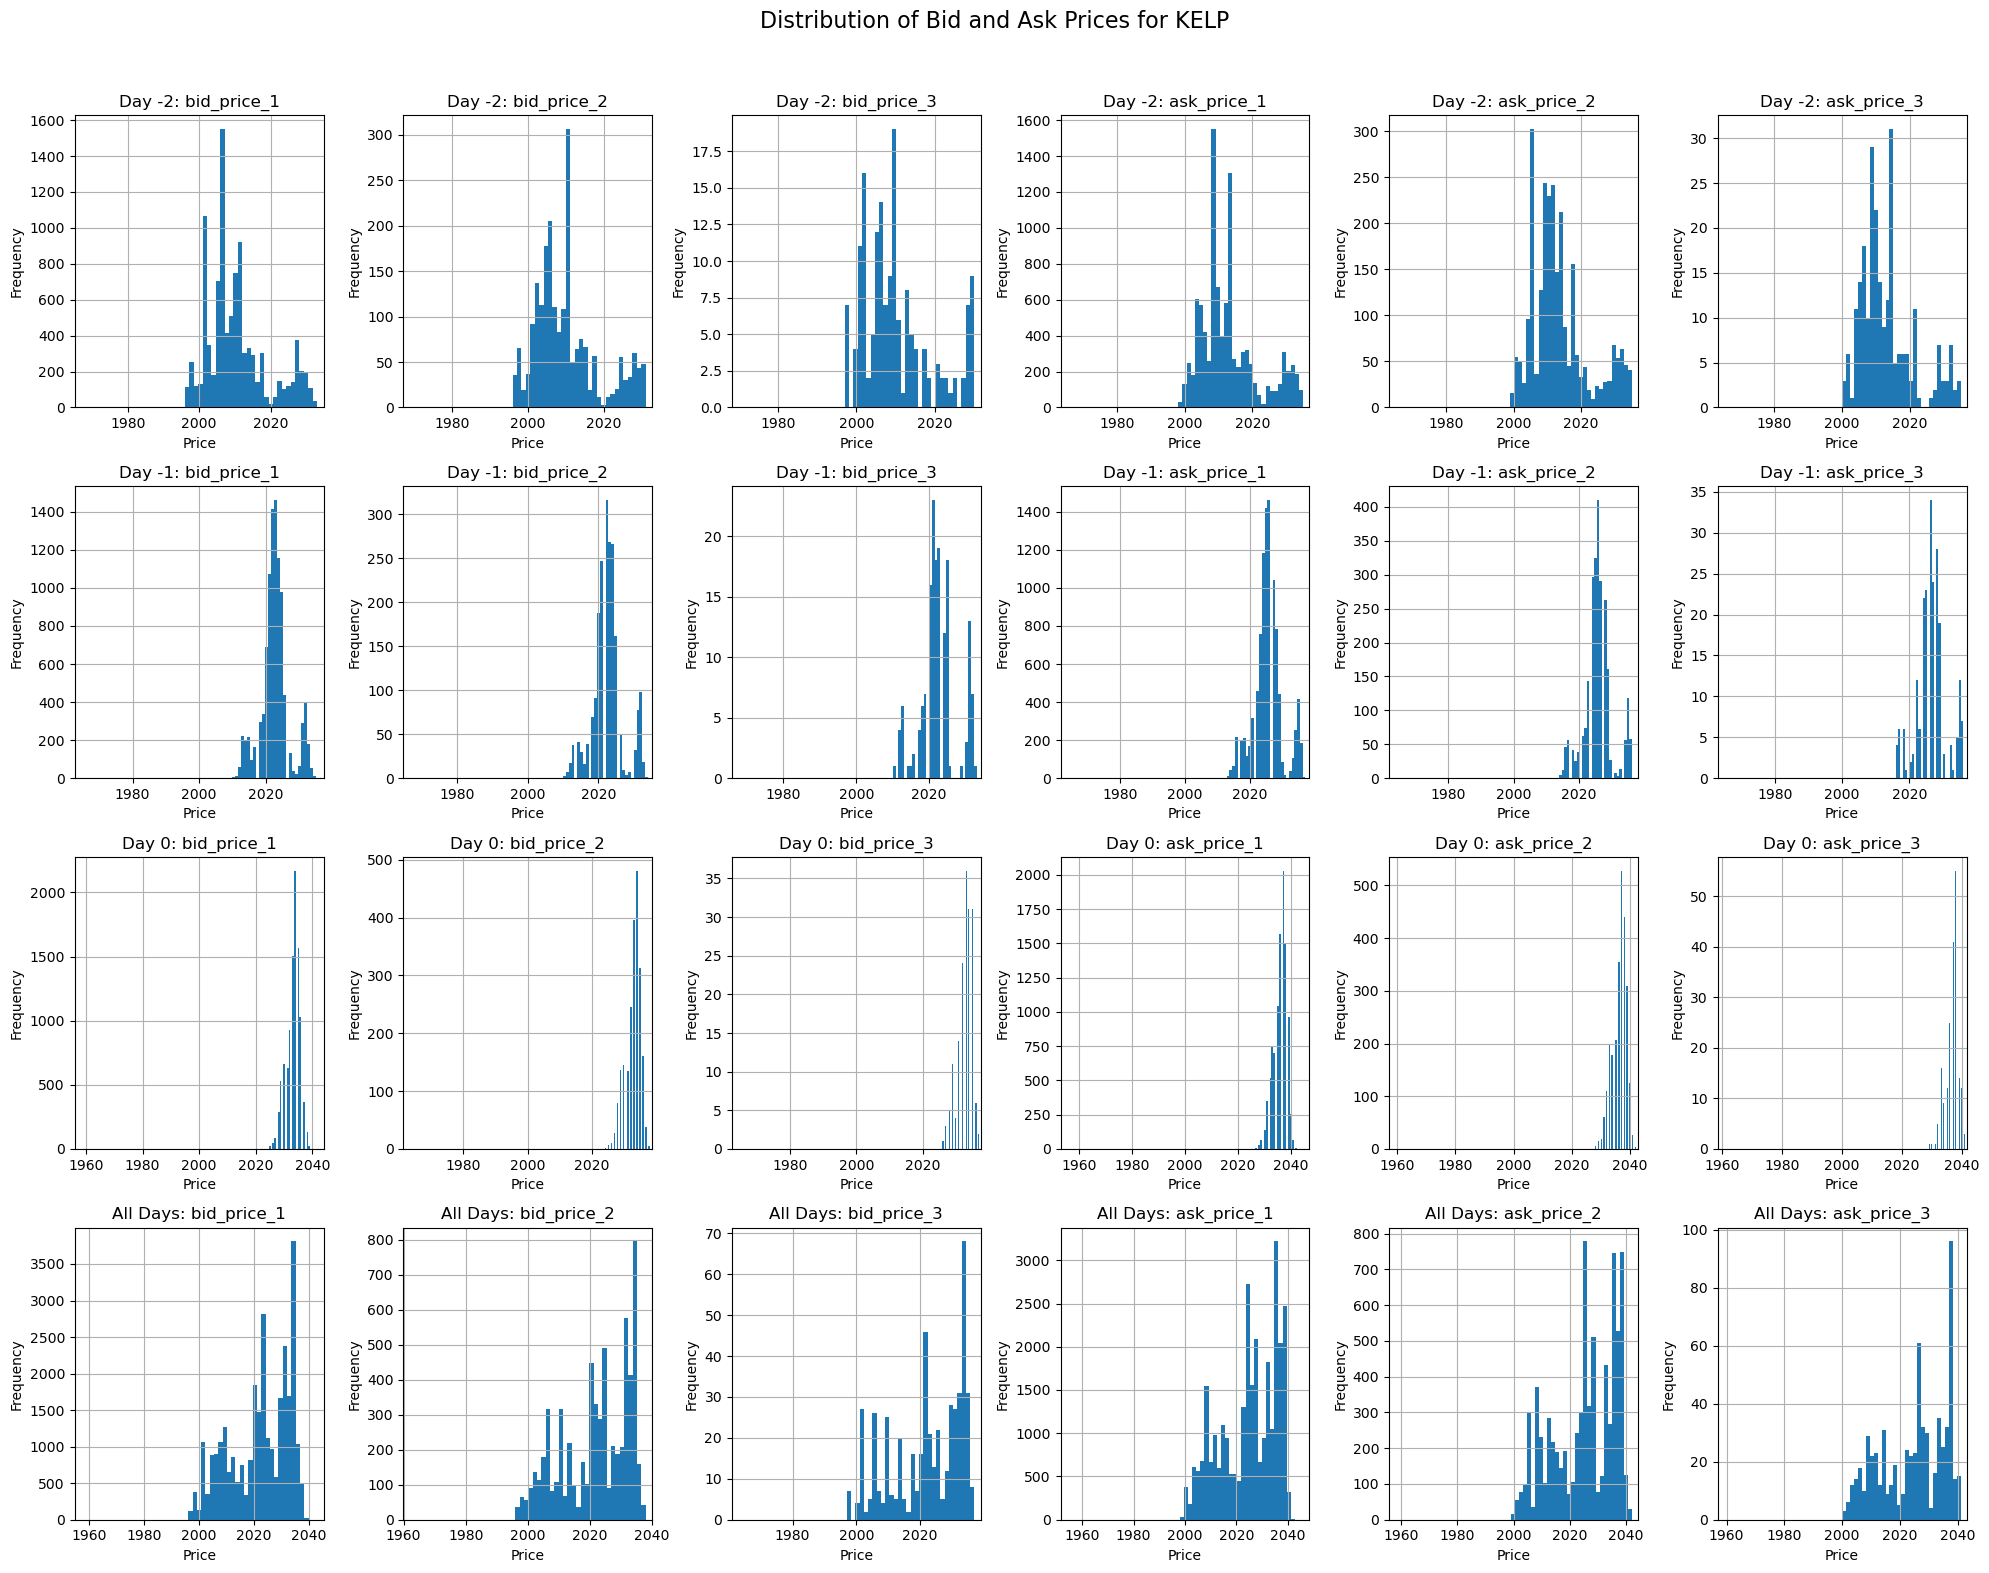

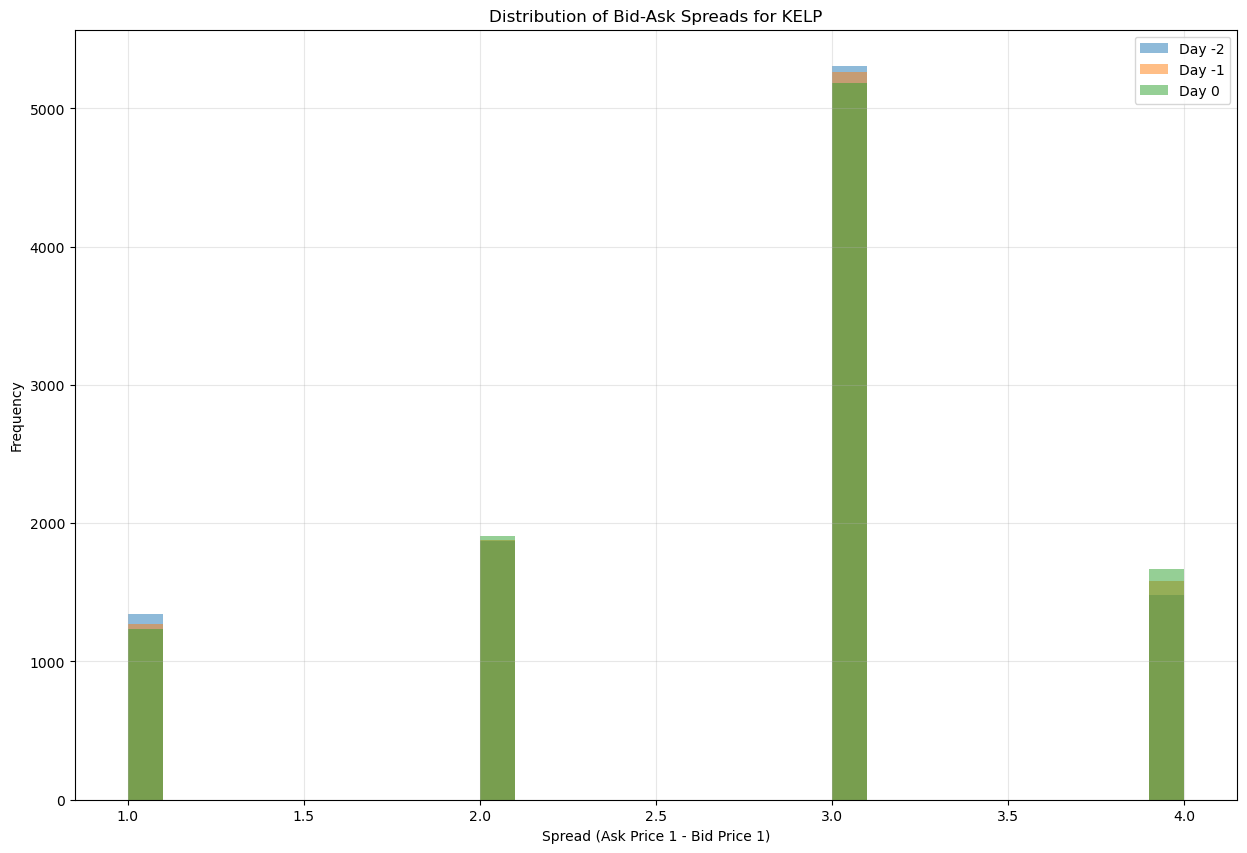

In [31]:

# Define the columns to plot
bid_columns = ['bid_price_1', 'bid_price_2', 'bid_price_3']
ask_columns = ['ask_price_1', 'ask_price_2', 'ask_price_3']
all_columns = bid_columns + ask_columns

# Create a 4x6 grid of subplots (4 datasets x 6 price columns)
fig, axes = plt.subplots(4, 6, figsize=(20, 16))
fig.suptitle('Distribution of Bid and Ask Prices for KELP', fontsize=16)

# Plot for day -2
for i, col in enumerate(all_columns):
    if col in prices_day__2.columns:
        prices_day__2[col].dropna().hist(ax=axes[0, i], bins=30)
        axes[0, i].set_title(f'Day -2: {col}')
        axes[0, i].set_xlabel('Price')
        axes[0, i].set_ylabel('Frequency')
        # Center x-axis at 2000
        x_min, x_max = axes[0, i].get_xlim()
        margin = max(abs(2000 - x_min), abs(2000 - x_max))
        axes[0, i].set_xlim(2000 - margin, 2000 + margin)

# Plot for day -1
for i, col in enumerate(all_columns):
    if col in prices_day__1.columns:
        prices_day__1[col].dropna().hist(ax=axes[1, i], bins=30)
        axes[1, i].set_title(f'Day -1: {col}')
        axes[1, i].set_xlabel('Price')
        axes[1, i].set_ylabel('Frequency')
        # Center x-axis at 2000
        x_min, x_max = axes[1, i].get_xlim()
        margin = max(abs(2000 - x_min), abs(2000 - x_max))
        axes[1, i].set_xlim(2000 - margin, 2000 + margin)

# Plot for day 0
for i, col in enumerate(all_columns):
    if col in prices_day_0.columns:
        prices_day_0[col].dropna().hist(ax=axes[2, i], bins=30)
        axes[2, i].set_title(f'Day 0: {col}')
        axes[2, i].set_xlabel('Price')
        axes[2, i].set_ylabel('Frequency')
        # Center x-axis at 2000
        x_min, x_max = axes[2, i].get_xlim()
        margin = max(abs(2000 - x_min), abs(2000 - x_max))
        axes[2, i].set_xlim(2000 - margin, 2000 + margin)

# Plot for all days combined
for i, col in enumerate(all_columns):
    if col in all_prices.columns:
        all_prices[col].dropna().hist(ax=axes[3, i], bins=30)
        axes[3, i].set_title(f'All Days: {col}')
        axes[3, i].set_xlabel('Price')
        axes[3, i].set_ylabel('Frequency')
        # Center x-axis at 2000
        x_min, x_max = axes[3, i].get_xlim()
        margin = max(abs(2000 - x_min), abs(2000 - x_max))
        axes[3, i].set_xlim(2000 - margin, 2000 + margin)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Create a second figure to compare bid-ask spreads
plt.figure(figsize=(15, 10))

# Calculate best bid-ask spread for each day
for df, day in [(prices_day__2, '-2'), (prices_day__1, '-1'), (prices_day_0, '0')]:
    best_bid = df['bid_price_1'].dropna()
    best_ask = df['ask_price_1'].dropna()
    
    # Only calculate spread where both bid and ask exist
    valid_indices = best_bid.index.intersection(best_ask.index)
    if len(valid_indices) > 0:
        spread = df.loc[valid_indices, 'ask_price_1'] - df.loc[valid_indices, 'bid_price_1']
        plt.hist(spread, bins=30, alpha=0.5, label=f'Day {day}')

plt.title('Distribution of Bid-Ask Spreads for KELP')
plt.xlabel('Spread (Ask Price 1 - Bid Price 1)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
# Do not center x-axis
plt.show()


In [6]:
# Example features:

all_prices['spread_1'] = all_prices['ask_price_1'] - all_prices['bid_price_1']

# Total bid volume (levels 1..3)
all_prices['total_bid_vol'] = (all_prices['bid_volume_1'] +
                               all_prices['bid_volume_2'] +
                               all_prices['bid_volume_3'])

# Total ask volume (levels 1..3)
all_prices['total_ask_vol'] = (all_prices['ask_volume_1'] +
                               all_prices['ask_volume_2'] +
                               all_prices['ask_volume_3'])

# Order book volume imbalance
all_prices['volume_imbalance'] = (
    all_prices['total_bid_vol'] / (all_prices['total_bid_vol'] + all_prices['total_ask_vol'] + 1e-9)
)

# Rolling feature: for example, a 5-row rolling average of mid_price
all_prices['mid_price_rolling_mean'] = all_prices['mid_price'].rolling(window=5).mean()
all_prices['mid_price_rolling_mean'].fillna(method='bfill', inplace=True)

# Momentum-like feature
all_prices['momentum'] = all_prices['mid_price'] - all_prices['mid_price_rolling_mean']

# You can add many other features similarly...


C:\Users\Usuario1\AppData\Local\Temp\ipykernel_31604\401788274.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_prices['mid_price_rolling_mean'].fillna(method='bfill', inplace=True)
C:\Users\Usuario1\AppData\Local\Temp\ipykernel_31604\401788274.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_prices['mid_price_rolling_mean'].fillna(method='bfill', inplace=True)
